# Logistic Regression 
<p> Implement multiclass logistic regression for MNIST. You should try both PCA and LDA for dimensionality reduction, first. In brief, multiclass logistic regression models the class posteriors of an image log-linearly in terms of its features so that 

$$
P\left(y_{m, n}=1 \mid \mathbf{x}_n\right)=\frac{\exp \left(\boldsymbol{\theta}_m^{\top} \mathbf{x}_n\right)}{\sum_{i=1}^M \exp \left(\boldsymbol{\theta}_i^{\top} \mathbf{x}_n\right)}
$$

i.e. the
softmax function, where ym,n is the indicator of xn being in class ωm. The model
parameters are estimated to minimize the negative log-likelihood of the class labels,
which are encoded as categorical vectors. The negative log-likelihood takes the form
$$
\ell\left(\boldsymbol{\theta}_1, \cdots, \boldsymbol{\theta}_M\right)=-\sum_{n=1}^N \sum_{m=1}^M y_{m, n} \ln \left(\frac{\exp \left(\boldsymbol{\theta}_m^{\top} \mathbf{x}_n\right)}{\sum_{i=1}^M \exp \left(\boldsymbol{\theta}_i^{\top} \mathbf{x}_n\right)}\right)
$$


; this is sometimes called
the cross-entropy loss function.

In [1]:
import numpy as np
import pandas as pd

from tqdm import tqdm
from utils import *


In [2]:
import warnings
warnings.filterwarnings('ignore')


In [3]:
np.random.seed(1024)


>> If Running for the first time Uncomment and run the following cell

In [4]:
## train_load,test_load = load_dataset(False)


In [22]:
# Load Downloaded Data and Normalize
from mlxtend.data import loadlocal_mnist
from sklearn.preprocessing import StandardScaler
import platform

original_train_X, original_train_y = loadlocal_mnist(
    images_path='dataset/MNIST/raw/train-images-idx3-ubyte',
    labels_path='dataset/MNIST/raw/train-labels-idx1-ubyte')

original_test_X, original_test_y = loadlocal_mnist(
    images_path='dataset/MNIST/raw/t10k-images-idx3-ubyte',
    labels_path='dataset/MNIST/raw/t10k-labels-idx1-ubyte')

train_X, train_y = original_train_X, original_train_y

test_X, test_y = original_test_X, original_test_y

# Normalize Data:
sc = StandardScaler()

# First fit then transform
train_X = sc.fit_transform(train_X)
test_X = sc.transform(test_X)
N = train_X.shape[1]
C = len(set(train_y))
assert (C == 10)
train_X.shape, train_y.shape, test_X.shape, test_y.shape


((60000, 784), (60000,), (10000, 784), (10000,))

>> Set hyperparameters to loop and train

In [6]:
from numpy import random
from utils import *


In [7]:
# Predict and calculate metrics
def test(x, y, w, b) -> tuple[float, float]:
    try:
        samples = len(y)
        idx = [np.squeeze(softmax((x[i] @ w.T))) for i in range(samples)]
        idx = np.array(np.array(idx))
        correct = sum(np.argmax(idx, axis=1) == y)/samples
        error = [negative_log_likelihood(idx[i], y[i]) for i in range(samples)]
        return correct, sum(error)
    except Exception as ex:
        print(ex)


In [24]:
def LogisticRegression(train_X, test_X, train_y, test_y, lr=0.0025, batch_size=100, epoch=15):
    H, N = train_X.shape[0], train_X.shape[1]
    # Initialize momentum:
    w = random.randn(C, N) / np.sqrt(C*N)
    b = random.rand(C, 1)/np.sqrt(N)
    epoch_result1 = []
    epoch_result2 = []
    epoch_result3 = []
    epoch_result4 = []
    w_dash = np.zeros(w.shape)
    b_dash = np.zeros(b.shape)
    loss = 0
    accuraccy = []
    for iter in tqdm(range(epoch)):
        shuffle = random.choice(H, H, replace=False)

        # Divide data in batches:
        total_batches = int(H/batch_size)
        train_X_chunks = np.array_split(train_X, total_batches)
        train_y_chunks = np.array_split(train_y, total_batches)
        for batch in range(total_batches):
            x = train_X_chunks[batch]
            y = train_y_chunks[batch]
            # loss = 0

            lst_dw, lst_db = [], []
            for point in range(x.shape[0]):
                x_p = (x[point]).reshape((N, 1))
                y_p = y[point]
                # Predict
                y_hat_ = softmax((w@x_p)+b)
                # Get Loss
                loss += negative_log_likelihood(y_hat_, y_p)
                # Get gradients:
                k = np.zeros((10, 1))
                k[y_p][0] = 1
                lst_dw.append(-1*((k-y_hat_) @ x_p.reshape((1, N))))
                lst_db.append(-1*(k-y_hat_))

            # Momentum:
            w_dash = 0.9*w_dash + lr*(sum(lst_dw)/(x.shape[0]))
            b_dash = 0.9*b_dash+lr*(sum(lst_db)/(x.shape[0]))
            w -= w_dash
            b -= b_dash
            #print('\t\t-- ',iter,' : ',loss,' --')
        train_acc, train_loss = test(train_X, train_y, w, b)
        epoch_result1.append(train_acc)
        epoch_result2.append(train_loss/float(100))

        print('-- Train: ', iter, ': Accuraccy = ', train_acc,
              '\tError: ', train_loss/float(100), ' --')
        test_acc, test_loss = test(test_X, test_y, w, b)
        print('-- Test: ', iter, ': Accuraccy = ', test_acc,
              '\tError: ', test_loss/float(100), ' --')
        epoch_result3.append(test_acc)
        epoch_result4.append(test_loss/float(100))

    # Plot Training Results
    plt.plot(range(epoch), epoch_result1, 'g', label='Training Accuraccy')
    plt.title('Training accuraccy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    # Plot Training Results
    plt.plot(range(epoch), epoch_result2, 'r', label='Training loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    # Plot Testing Results
    plt.plot(range(epoch), epoch_result3, 'g', label='Testing Accuraccy')
    plt.title('Testing accuraccy ')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    # Plot Testing Results
    plt.plot(range(epoch), epoch_result4, 'r', label='Testing loss')
    plt.title('Testing loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return [epoch_result1, epoch_result2, epoch_result3, epoch_result4]


  7%|▋         | 1/15 [00:04<01:00,  4.29s/it]

-- Train:  0 : Accuraccy =  0.8807166666666667 	Error:  268.2633991996311  --
-- Test:  0 : Accuraccy =  0.8848 	Error:  43.547988196162976  --


 13%|█▎        | 2/15 [00:08<00:57,  4.44s/it]

-- Train:  1 : Accuraccy =  0.8956833333333334 	Error:  229.13691327262026  --
-- Test:  1 : Accuraccy =  0.8986 	Error:  37.35315754574651  --


 20%|██        | 3/15 [00:13<00:54,  4.50s/it]

-- Train:  2 : Accuraccy =  0.9018833333333334 	Error:  212.3397253976775  --
-- Test:  2 : Accuraccy =  0.9024 	Error:  34.7762408060336  --


 27%|██▋       | 4/15 [00:18<00:50,  4.57s/it]

-- Train:  3 : Accuraccy =  0.9057833333333334 	Error:  202.43752463408563  --
-- Test:  3 : Accuraccy =  0.9059 	Error:  33.30612253622273  --


 33%|███▎      | 5/15 [00:22<00:45,  4.60s/it]

-- Train:  4 : Accuraccy =  0.9084666666666666 	Error:  195.73140109521992  --
-- Test:  4 : Accuraccy =  0.908 	Error:  32.34287847975802  --


 40%|████      | 6/15 [00:27<00:41,  4.60s/it]

-- Train:  5 : Accuraccy =  0.9106333333333333 	Error:  190.8126332266977  --
-- Test:  5 : Accuraccy =  0.9092 	Error:  31.659575417224758  --


 47%|████▋     | 7/15 [00:31<00:36,  4.59s/it]

-- Train:  6 : Accuraccy =  0.9123166666666667 	Error:  187.0138764383951  --
-- Test:  6 : Accuraccy =  0.9104 	Error:  31.15002171339458  --


 53%|█████▎    | 8/15 [00:36<00:32,  4.60s/it]

-- Train:  7 : Accuraccy =  0.9137666666666666 	Error:  183.9711880376212  --
-- Test:  7 : Accuraccy =  0.9117 	Error:  30.756651717123454  --


 60%|██████    | 9/15 [00:41<00:27,  4.63s/it]

-- Train:  8 : Accuraccy =  0.91495 	Error:  181.46703961355735  --
-- Test:  8 : Accuraccy =  0.9129 	Error:  30.445038450164496  --


 67%|██████▋   | 10/15 [00:45<00:23,  4.62s/it]

-- Train:  9 : Accuraccy =  0.9159166666666667 	Error:  179.36262627473982  --
-- Test:  9 : Accuraccy =  0.9134 	Error:  30.193287263706626  --


 73%|███████▎  | 11/15 [00:50<00:18,  4.64s/it]

-- Train:  10 : Accuraccy =  0.9167166666666666 	Error:  177.56464730074106  --
-- Test:  10 : Accuraccy =  0.9146 	Error:  29.986762832563592  --


 80%|████████  | 12/15 [00:55<00:13,  4.66s/it]

-- Train:  11 : Accuraccy =  0.9171333333333334 	Error:  176.00768268525934  --
-- Test:  11 : Accuraccy =  0.9154 	Error:  29.81527880131742  --


 87%|████████▋ | 13/15 [00:59<00:09,  4.69s/it]

-- Train:  12 : Accuraccy =  0.91765 	Error:  174.64422443888193  --
-- Test:  12 : Accuraccy =  0.9157 	Error:  29.67151025165049  --


 93%|█████████▎| 14/15 [01:04<00:04,  4.69s/it]

-- Train:  13 : Accuraccy =  0.9184166666666667 	Error:  173.4387931374934  --
-- Test:  13 : Accuraccy =  0.9163 	Error:  29.55004042458934  --


100%|██████████| 15/15 [01:09<00:00,  4.63s/it]

-- Train:  14 : Accuraccy =  0.919 	Error:  172.36434395519998  --
-- Test:  14 : Accuraccy =  0.916 	Error:  29.446774373369603  --


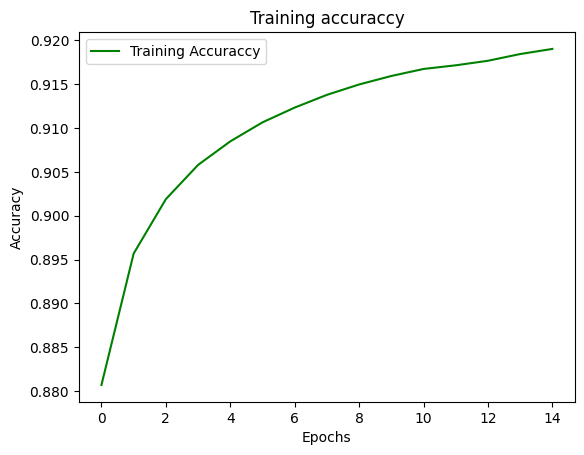

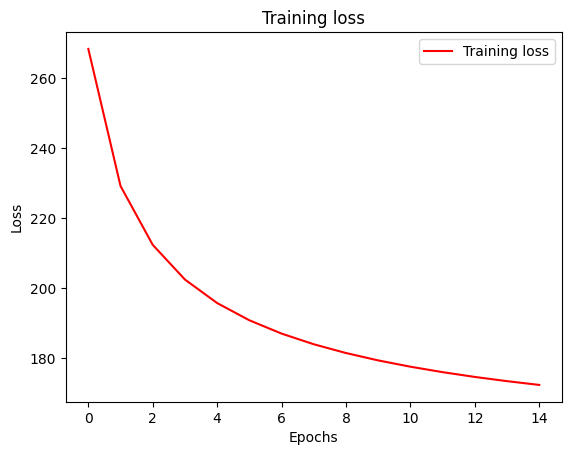

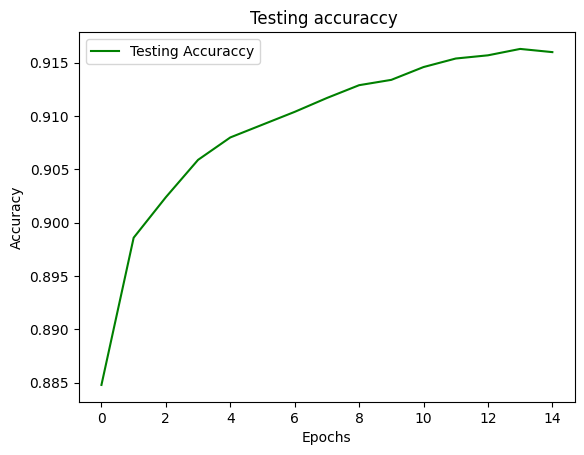

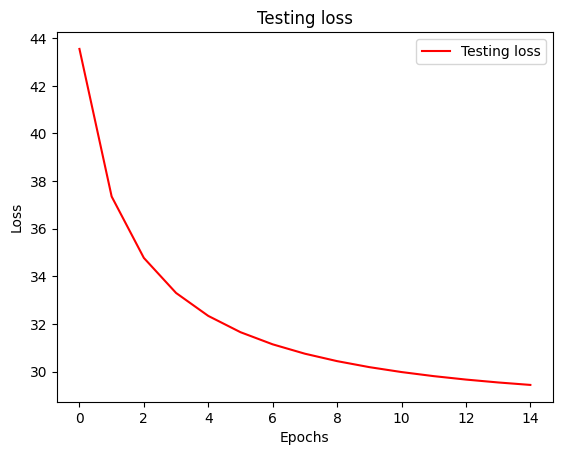

In [9]:
result = LogisticRegression(
    train_X, test_X, train_y, test_y, lr=0.0025, batch_size=500, epoch=15)


In [20]:
best_train_acc = result[0]
best_test_acc = result[2]

best_train_acc = best_train_acc[np.argmax(best_train_acc)]
best_test_acc = best_test_acc[np.argmax(best_test_acc)]

best_train_acc, best_test_acc


(0.9237666666666666, 0.9168)

  1%|          | 1/100 [00:02<04:52,  2.96s/it]

-- Train:  0 : Accuraccy =  0.9126833333333333 	Error:  184.98225795933845  --
-- Test:  0 : Accuraccy =  0.9101 	Error:  31.47007615364484  --


  2%|▏         | 2/100 [00:05<04:51,  2.98s/it]

-- Train:  1 : Accuraccy =  0.91875 	Error:  173.20712476400547  --
-- Test:  1 : Accuraccy =  0.9139 	Error:  30.48869005398944  --


  3%|▎         | 3/100 [00:09<04:53,  3.02s/it]

-- Train:  2 : Accuraccy =  0.92105 	Error:  167.79883592770489  --
-- Test:  2 : Accuraccy =  0.9162 	Error:  29.935155542552625  --


  4%|▍         | 4/100 [00:12<04:49,  3.01s/it]

-- Train:  3 : Accuraccy =  0.9224 	Error:  165.425320605757  --
-- Test:  3 : Accuraccy =  0.9158 	Error:  30.078804046324638  --


  5%|▌         | 5/100 [00:15<04:47,  3.02s/it]

-- Train:  4 : Accuraccy =  0.923 	Error:  164.50638150971233  --
-- Test:  4 : Accuraccy =  0.9164 	Error:  30.491800994895694  --


  6%|▌         | 6/100 [00:18<04:46,  3.04s/it]

-- Train:  5 : Accuraccy =  0.9232833333333333 	Error:  163.132105925676  --
-- Test:  5 : Accuraccy =  0.9161 	Error:  30.342059937710648  --


  7%|▋         | 7/100 [00:21<04:44,  3.06s/it]

-- Train:  6 : Accuraccy =  0.9237666666666666 	Error:  163.0063746124557  --
-- Test:  6 : Accuraccy =  0.9163 	Error:  30.66136543383792  --


  8%|▊         | 8/100 [00:24<04:41,  3.06s/it]

-- Train:  7 : Accuraccy =  0.9235333333333333 	Error:  162.979598339235  --
-- Test:  7 : Accuraccy =  0.9167 	Error:  31.003094624873384  --


  9%|▉         | 9/100 [00:27<04:38,  3.06s/it]

-- Train:  8 : Accuraccy =  0.9232833333333333 	Error:  162.6442779809175  --
-- Test:  8 : Accuraccy =  0.9168 	Error:  30.950968405888858  --


 10%|█         | 10/100 [00:30<04:38,  3.10s/it]

-- Train:  9 : Accuraccy =  0.9232666666666667 	Error:  163.11157514586398  --
-- Test:  9 : Accuraccy =  0.9166 	Error:  31.26083693506378  --


 11%|█         | 11/100 [00:33<04:38,  3.13s/it]

-- Train:  10 : Accuraccy =  0.9227833333333333 	Error:  163.66835990116422  --
-- Test:  10 : Accuraccy =  0.9161 	Error:  31.627991194129734  --


 12%|█▏        | 12/100 [00:37<04:44,  3.23s/it]

-- Train:  11 : Accuraccy =  0.92265 	Error:  163.56764032231166  --
-- Test:  11 : Accuraccy =  0.9158 	Error:  31.57400165956418  --


 13%|█▎        | 13/100 [00:40<04:51,  3.35s/it]

-- Train:  12 : Accuraccy =  0.9221833333333334 	Error:  164.12525099927478  --
-- Test:  12 : Accuraccy =  0.9148 	Error:  31.85362447547188  --


 14%|█▍        | 14/100 [00:43<04:42,  3.28s/it]

-- Train:  13 : Accuraccy =  0.92175 	Error:  164.6874809572611  --
-- Test:  13 : Accuraccy =  0.9144 	Error:  32.23782201869855  --


 15%|█▌        | 15/100 [00:47<04:37,  3.26s/it]

-- Train:  14 : Accuraccy =  0.9211833333333334 	Error:  165.3031421897771  --
-- Test:  14 : Accuraccy =  0.9136 	Error:  32.317322243852104  --


 16%|█▌        | 16/100 [00:50<04:33,  3.26s/it]

-- Train:  15 : Accuraccy =  0.9205333333333333 	Error:  165.97069263562312  --
-- Test:  15 : Accuraccy =  0.9132 	Error:  32.52860682705767  --


 17%|█▋        | 17/100 [00:54<04:40,  3.38s/it]

-- Train:  16 : Accuraccy =  0.9201 	Error:  166.7999087409748  --
-- Test:  16 : Accuraccy =  0.9128 	Error:  32.89386896179367  --


 18%|█▊        | 18/100 [00:57<04:31,  3.31s/it]

-- Train:  17 : Accuraccy =  0.9195666666666666 	Error:  167.29830330718175  --
-- Test:  17 : Accuraccy =  0.9125 	Error:  32.980139935628856  --


 19%|█▉        | 19/100 [01:00<04:26,  3.29s/it]

-- Train:  18 : Accuraccy =  0.9192166666666667 	Error:  168.0617714648176  --
-- Test:  18 : Accuraccy =  0.9118 	Error:  33.21779656489809  --


 20%|██        | 20/100 [01:04<04:32,  3.40s/it]

-- Train:  19 : Accuraccy =  0.9187 	Error:  168.98041369836582  --
-- Test:  19 : Accuraccy =  0.9105 	Error:  33.61331056626588  --


 21%|██        | 21/100 [01:07<04:24,  3.34s/it]

-- Train:  20 : Accuraccy =  0.9181666666666667 	Error:  169.69230119957294  --
-- Test:  20 : Accuraccy =  0.9098 	Error:  33.69252572867144  --


 22%|██▏       | 22/100 [01:10<04:14,  3.27s/it]

-- Train:  21 : Accuraccy =  0.9178333333333333 	Error:  170.30122304958263  --
-- Test:  21 : Accuraccy =  0.9092 	Error:  33.90034583563007  --


 23%|██▎       | 23/100 [01:13<04:06,  3.20s/it]

-- Train:  22 : Accuraccy =  0.9171833333333334 	Error:  171.24116048495955  --
-- Test:  22 : Accuraccy =  0.9082 	Error:  34.23863912264184  --


 24%|██▍       | 24/100 [01:16<03:59,  3.15s/it]

-- Train:  23 : Accuraccy =  0.9166833333333333 	Error:  171.97509981429113  --
-- Test:  23 : Accuraccy =  0.908 	Error:  34.33385465480196  --


 25%|██▌       | 25/100 [01:19<03:54,  3.13s/it]

-- Train:  24 : Accuraccy =  0.9162166666666667 	Error:  172.86465630592582  --
-- Test:  24 : Accuraccy =  0.9076 	Error:  34.66698125567644  --


 26%|██▌       | 26/100 [01:22<03:49,  3.10s/it]

-- Train:  25 : Accuraccy =  0.9157333333333333 	Error:  173.498542445606  --
-- Test:  25 : Accuraccy =  0.9073 	Error:  34.77749712325105  --


 27%|██▋       | 27/100 [01:25<03:44,  3.08s/it]

-- Train:  26 : Accuraccy =  0.9151 	Error:  174.33663928358158  --
-- Test:  26 : Accuraccy =  0.9068 	Error:  34.99249079731359  --


 28%|██▊       | 28/100 [01:28<03:40,  3.07s/it]

-- Train:  27 : Accuraccy =  0.9148333333333334 	Error:  175.24607034817262  --
-- Test:  27 : Accuraccy =  0.9061 	Error:  35.311479627663196  --


 29%|██▉       | 29/100 [01:31<03:37,  3.07s/it]

-- Train:  28 : Accuraccy =  0.9141166666666667 	Error:  176.02369459662845  --
-- Test:  28 : Accuraccy =  0.9056 	Error:  35.413724958948926  --


 30%|███       | 30/100 [01:34<03:36,  3.09s/it]

-- Train:  29 : Accuraccy =  0.91375 	Error:  176.76176762480657  --
-- Test:  29 : Accuraccy =  0.9048 	Error:  35.71121255761517  --


 31%|███       | 31/100 [01:38<03:38,  3.17s/it]

-- Train:  30 : Accuraccy =  0.91325 	Error:  177.6184769160914  --
-- Test:  30 : Accuraccy =  0.9046 	Error:  35.92874408408237  --


 32%|███▏      | 32/100 [01:41<03:43,  3.29s/it]

-- Train:  31 : Accuraccy =  0.9127166666666666 	Error:  178.43947007009436  --
-- Test:  31 : Accuraccy =  0.9044 	Error:  36.02203849702404  --


 33%|███▎      | 33/100 [01:45<03:38,  3.26s/it]

-- Train:  32 : Accuraccy =  0.912 	Error:  179.2162824619006  --
-- Test:  32 : Accuraccy =  0.904 	Error:  36.226637346070305  --


 34%|███▍      | 34/100 [01:48<03:32,  3.21s/it]

-- Train:  33 : Accuraccy =  0.9114166666666667 	Error:  180.052838856333  --
-- Test:  33 : Accuraccy =  0.9032 	Error:  36.517142956235965  --


 35%|███▌      | 35/100 [01:51<03:27,  3.19s/it]

-- Train:  34 : Accuraccy =  0.91075 	Error:  180.84813757223765  --
-- Test:  34 : Accuraccy =  0.9028 	Error:  36.72638852539978  --


 36%|███▌      | 36/100 [01:54<03:21,  3.15s/it]

-- Train:  35 : Accuraccy =  0.91065 	Error:  181.5818511192159  --
-- Test:  35 : Accuraccy =  0.902 	Error:  36.80907759266244  --


 37%|███▋      | 37/100 [01:57<03:18,  3.15s/it]

-- Train:  36 : Accuraccy =  0.9100333333333334 	Error:  182.40449774613265  --
-- Test:  36 : Accuraccy =  0.9017 	Error:  37.00544337014745  --


 38%|███▊      | 38/100 [02:00<03:19,  3.23s/it]

-- Train:  37 : Accuraccy =  0.90965 	Error:  183.11006858946007  --
-- Test:  37 : Accuraccy =  0.9011 	Error:  37.27850536106724  --


 39%|███▉      | 39/100 [02:04<03:21,  3.30s/it]

-- Train:  38 : Accuraccy =  0.9092666666666667 	Error:  183.94306941016802  --
-- Test:  38 : Accuraccy =  0.9012 	Error:  37.47353572176919  --


 40%|████      | 40/100 [02:07<03:23,  3.39s/it]

-- Train:  39 : Accuraccy =  0.9086 	Error:  184.73491684206692  --
-- Test:  39 : Accuraccy =  0.9004 	Error:  37.59654978677392  --


 41%|████      | 41/100 [02:11<03:17,  3.34s/it]

-- Train:  40 : Accuraccy =  0.9081 	Error:  185.54104050889873  --
-- Test:  40 : Accuraccy =  0.9 	Error:  37.86415181395993  --


 42%|████▏     | 42/100 [02:14<03:09,  3.26s/it]

-- Train:  41 : Accuraccy =  0.9076666666666666 	Error:  186.28940097424262  --
-- Test:  41 : Accuraccy =  0.8996 	Error:  37.937946297098186  --


 43%|████▎     | 43/100 [02:17<03:02,  3.20s/it]

-- Train:  42 : Accuraccy =  0.9072833333333333 	Error:  186.9551776112148  --
-- Test:  42 : Accuraccy =  0.8986 	Error:  38.20144335443219  --


 44%|████▍     | 44/100 [02:20<02:57,  3.17s/it]

-- Train:  43 : Accuraccy =  0.90655 	Error:  187.77411686551255  --
-- Test:  43 : Accuraccy =  0.8979 	Error:  38.38954951348557  --


 45%|████▌     | 45/100 [02:23<02:54,  3.18s/it]

-- Train:  44 : Accuraccy =  0.9061833333333333 	Error:  188.53367002031024  --
-- Test:  44 : Accuraccy =  0.8978 	Error:  38.46302605986536  --


 46%|████▌     | 46/100 [02:26<02:54,  3.23s/it]

-- Train:  45 : Accuraccy =  0.9056333333333333 	Error:  189.33793433971903  --
-- Test:  45 : Accuraccy =  0.8974 	Error:  38.71143244837769  --


 47%|████▋     | 47/100 [02:30<02:54,  3.29s/it]

-- Train:  46 : Accuraccy =  0.90505 	Error:  189.95013780780334  --
-- Test:  46 : Accuraccy =  0.8971 	Error:  38.81129320813137  --


 48%|████▊     | 48/100 [02:33<02:52,  3.32s/it]

-- Train:  47 : Accuraccy =  0.90465 	Error:  190.7730089673604  --
-- Test:  47 : Accuraccy =  0.8965 	Error:  39.0457782668254  --


 49%|████▉     | 49/100 [02:37<02:51,  3.36s/it]

-- Train:  48 : Accuraccy =  0.9041833333333333 	Error:  191.5751932659475  --
-- Test:  48 : Accuraccy =  0.8961 	Error:  39.266815699507426  --


 50%|█████     | 50/100 [02:40<02:48,  3.38s/it]

-- Train:  49 : Accuraccy =  0.9039666666666667 	Error:  192.183494585388  --
-- Test:  49 : Accuraccy =  0.8962 	Error:  39.321192570753226  --


 51%|█████     | 51/100 [02:44<02:46,  3.39s/it]

-- Train:  50 : Accuraccy =  0.9035666666666666 	Error:  192.98194082618483  --
-- Test:  50 : Accuraccy =  0.8955 	Error:  39.49004111858086  --


 52%|█████▏    | 52/100 [02:47<02:43,  3.41s/it]

-- Train:  51 : Accuraccy =  0.9033166666666667 	Error:  193.76789996887612  --
-- Test:  51 : Accuraccy =  0.8956 	Error:  39.72009514135679  --


 53%|█████▎    | 53/100 [02:50<02:41,  3.43s/it]

-- Train:  52 : Accuraccy =  0.9028666666666667 	Error:  194.36083880211103  --
-- Test:  52 : Accuraccy =  0.8953 	Error:  39.8704045417177  --


 54%|█████▍    | 54/100 [02:54<02:34,  3.36s/it]

-- Train:  53 : Accuraccy =  0.9023333333333333 	Error:  195.14977857852503  --
-- Test:  53 : Accuraccy =  0.8951 	Error:  40.04042558060749  --


 55%|█████▌    | 55/100 [02:57<02:29,  3.32s/it]

-- Train:  54 : Accuraccy =  0.9019833333333334 	Error:  195.90425237508714  --
-- Test:  54 : Accuraccy =  0.8951 	Error:  40.19890053718349  --


 56%|█████▌    | 56/100 [03:00<02:22,  3.24s/it]

-- Train:  55 : Accuraccy =  0.9017 	Error:  196.60049287275288  --
-- Test:  55 : Accuraccy =  0.894 	Error:  40.36517773234553  --


 57%|█████▋    | 57/100 [03:03<02:16,  3.18s/it]

-- Train:  56 : Accuraccy =  0.9014 	Error:  197.3295833124223  --
-- Test:  56 : Accuraccy =  0.8935 	Error:  40.52138114296038  --


 58%|█████▊    | 58/100 [03:06<02:12,  3.16s/it]

-- Train:  57 : Accuraccy =  0.9010666666666667 	Error:  197.8994803444271  --
-- Test:  57 : Accuraccy =  0.8929 	Error:  40.69018192346627  --


 59%|█████▉    | 59/100 [03:09<02:11,  3.21s/it]

-- Train:  58 : Accuraccy =  0.9007166666666667 	Error:  198.67117515300134  --
-- Test:  58 : Accuraccy =  0.8926 	Error:  40.84597229894711  --


 60%|██████    | 60/100 [03:13<02:10,  3.27s/it]

-- Train:  59 : Accuraccy =  0.9004 	Error:  199.37575363163592  --
-- Test:  59 : Accuraccy =  0.8922 	Error:  40.911800228122026  --


 61%|██████    | 61/100 [03:16<02:10,  3.34s/it]

-- Train:  60 : Accuraccy =  0.9000333333333334 	Error:  200.07922953617725  --
-- Test:  60 : Accuraccy =  0.892 	Error:  41.07060061088683  --


 62%|██████▏   | 62/100 [03:20<02:08,  3.38s/it]

-- Train:  61 : Accuraccy =  0.89965 	Error:  200.72759046413958  --
-- Test:  61 : Accuraccy =  0.8914 	Error:  41.282054339372635  --


 63%|██████▎   | 63/100 [03:23<02:05,  3.39s/it]

-- Train:  62 : Accuraccy =  0.8991666666666667 	Error:  201.4662858440153  --
-- Test:  62 : Accuraccy =  0.8912 	Error:  41.42242141023485  --


 64%|██████▍   | 64/100 [03:27<02:02,  3.41s/it]

-- Train:  63 : Accuraccy =  0.8988 	Error:  202.00609984092145  --
-- Test:  63 : Accuraccy =  0.8906 	Error:  41.57731434619936  --


 65%|██████▌   | 65/100 [03:30<02:00,  3.43s/it]

-- Train:  64 : Accuraccy =  0.8983833333333333 	Error:  202.75539721618364  --
-- Test:  64 : Accuraccy =  0.8901 	Error:  41.7238635943236  --


 66%|██████▌   | 66/100 [03:34<01:56,  3.43s/it]

-- Train:  65 : Accuraccy =  0.8981 	Error:  203.46314826443745  --
-- Test:  65 : Accuraccy =  0.8898 	Error:  41.875080874268015  --


 67%|██████▋   | 67/100 [03:37<01:53,  3.45s/it]

-- Train:  66 : Accuraccy =  0.89775 	Error:  204.14796321904313  --
-- Test:  66 : Accuraccy =  0.8894 	Error:  42.016454797967256  --


 68%|██████▊   | 68/100 [03:40<01:49,  3.43s/it]

-- Train:  67 : Accuraccy =  0.8975666666666666 	Error:  204.68907233008179  --
-- Test:  67 : Accuraccy =  0.8893 	Error:  42.163432337414285  --


 69%|██████▉   | 69/100 [03:44<01:46,  3.43s/it]

-- Train:  68 : Accuraccy =  0.8972833333333333 	Error:  205.42141289362243  --
-- Test:  68 : Accuraccy =  0.8892 	Error:  42.302535634188736  --


 70%|███████   | 70/100 [03:47<01:42,  3.43s/it]

-- Train:  69 : Accuraccy =  0.89675 	Error:  206.10955530121703  --
-- Test:  69 : Accuraccy =  0.8891 	Error:  42.44717609502424  --


 71%|███████   | 71/100 [03:51<01:40,  3.45s/it]

-- Train:  70 : Accuraccy =  0.89645 	Error:  206.71413221254207  --
-- Test:  70 : Accuraccy =  0.8887 	Error:  42.58359192894165  --


 72%|███████▏  | 72/100 [03:54<01:34,  3.37s/it]

-- Train:  71 : Accuraccy =  0.8960666666666667 	Error:  207.40971446191296  --
-- Test:  71 : Accuraccy =  0.8885 	Error:  42.72707334794505  --


 73%|███████▎  | 73/100 [03:57<01:28,  3.30s/it]

-- Train:  72 : Accuraccy =  0.8955833333333333 	Error:  207.95476263997716  --
-- Test:  72 : Accuraccy =  0.8884 	Error:  42.86117472569919  --


 74%|███████▍  | 74/100 [04:00<01:24,  3.25s/it]

-- Train:  73 : Accuraccy =  0.89525 	Error:  208.65154717290633  --
-- Test:  73 : Accuraccy =  0.8879 	Error:  43.00279350876836  --


 75%|███████▌  | 75/100 [04:04<01:22,  3.31s/it]

-- Train:  74 : Accuraccy =  0.8950333333333333 	Error:  209.3349688392772  --
-- Test:  74 : Accuraccy =  0.8876 	Error:  43.135518524827695  --


 76%|███████▌  | 76/100 [04:07<01:22,  3.43s/it]

-- Train:  75 : Accuraccy =  0.8947833333333334 	Error:  209.81080887508455  --
-- Test:  75 : Accuraccy =  0.8869 	Error:  43.27369417589271  --


 77%|███████▋  | 77/100 [04:11<01:17,  3.38s/it]

-- Train:  76 : Accuraccy =  0.89445 	Error:  210.52269751446553  --
-- Test:  76 : Accuraccy =  0.8867 	Error:  43.40555781488249  --


 78%|███████▊  | 78/100 [04:14<01:13,  3.36s/it]

-- Train:  77 : Accuraccy =  0.8941166666666667 	Error:  211.17852375209065  --
-- Test:  77 : Accuraccy =  0.8862 	Error:  43.54213183500587  --


 79%|███████▉  | 79/100 [04:18<01:12,  3.47s/it]

-- Train:  78 : Accuraccy =  0.8939 	Error:  211.83842405601317  --
-- Test:  78 : Accuraccy =  0.8858 	Error:  43.67133162120392  --


 80%|████████  | 80/100 [04:21<01:07,  3.37s/it]

-- Train:  79 : Accuraccy =  0.8935333333333333 	Error:  212.26252091244245  --
-- Test:  79 : Accuraccy =  0.885 	Error:  43.80546810280213  --


 81%|████████  | 81/100 [04:24<01:02,  3.28s/it]

-- Train:  80 : Accuraccy =  0.8932166666666667 	Error:  212.97078351185326  --
-- Test:  80 : Accuraccy =  0.8848 	Error:  43.93375106698324  --


 82%|████████▏ | 82/100 [04:27<00:58,  3.23s/it]

-- Train:  81 : Accuraccy =  0.8928666666666667 	Error:  213.61138610900417  --
-- Test:  81 : Accuraccy =  0.8846 	Error:  44.06670727176479  --


 83%|████████▎ | 83/100 [04:30<00:55,  3.26s/it]

-- Train:  82 : Accuraccy =  0.8925333333333333 	Error:  214.27137085610832  --
-- Test:  82 : Accuraccy =  0.8843 	Error:  44.19220344671362  --


 84%|████████▍ | 84/100 [04:34<00:53,  3.34s/it]

-- Train:  83 : Accuraccy =  0.89225 	Error:  214.80968599542874  --
-- Test:  83 : Accuraccy =  0.884 	Error:  44.32350099560336  --


 85%|████████▌ | 85/100 [04:37<00:50,  3.33s/it]

-- Train:  84 : Accuraccy =  0.892 	Error:  215.47951305546565  --
-- Test:  84 : Accuraccy =  0.8836 	Error:  44.44734507622773  --


 86%|████████▌ | 86/100 [04:40<00:45,  3.26s/it]

-- Train:  85 : Accuraccy =  0.8917166666666667 	Error:  215.96501756006563  --
-- Test:  85 : Accuraccy =  0.8835 	Error:  44.576555609168416  --


 87%|████████▋ | 87/100 [04:43<00:41,  3.22s/it]

-- Train:  86 : Accuraccy =  0.8914166666666666 	Error:  216.63672745499125  --
-- Test:  86 : Accuraccy =  0.8832 	Error:  44.69878355627789  --


 88%|████████▊ | 88/100 [04:47<00:38,  3.22s/it]

-- Train:  87 : Accuraccy =  0.8911333333333333 	Error:  217.25160154628185  --
-- Test:  87 : Accuraccy =  0.8828 	Error:  44.82740934381557  --


 89%|████████▉ | 89/100 [04:50<00:36,  3.34s/it]

-- Train:  88 : Accuraccy =  0.8908833333333334 	Error:  217.66852619380256  --
-- Test:  88 : Accuraccy =  0.8828 	Error:  44.9455626457028  --


 90%|█████████ | 90/100 [04:53<00:32,  3.30s/it]

-- Train:  89 : Accuraccy =  0.8905333333333333 	Error:  218.3242419140615  --
-- Test:  89 : Accuraccy =  0.8826 	Error:  45.074280987750534  --


 91%|█████████ | 91/100 [04:57<00:29,  3.25s/it]

-- Train:  90 : Accuraccy =  0.89015 	Error:  218.95763663591563  --
-- Test:  90 : Accuraccy =  0.8822 	Error:  45.191330956902426  --


 92%|█████████▏| 92/100 [05:00<00:26,  3.29s/it]

-- Train:  91 : Accuraccy =  0.8897833333333334 	Error:  219.56596286786274  --
-- Test:  91 : Accuraccy =  0.8817 	Error:  45.3179277901348  --


 93%|█████████▎| 93/100 [05:04<00:23,  3.41s/it]

-- Train:  92 : Accuraccy =  0.8895 	Error:  220.0720288967207  --
-- Test:  92 : Accuraccy =  0.8817 	Error:  45.432541315578035  --


 94%|█████████▍| 94/100 [05:07<00:19,  3.29s/it]

-- Train:  93 : Accuraccy =  0.8891 	Error:  220.6959873250906  --
-- Test:  93 : Accuraccy =  0.8816 	Error:  45.55842733302335  --


 95%|█████████▌| 95/100 [05:10<00:16,  3.23s/it]

-- Train:  94 : Accuraccy =  0.8888 	Error:  221.28698369948904  --
-- Test:  94 : Accuraccy =  0.8812 	Error:  45.67136238810609  --


 96%|█████████▌| 96/100 [05:13<00:12,  3.17s/it]

-- Train:  95 : Accuraccy =  0.88855 	Error:  221.72499255437447  --
-- Test:  95 : Accuraccy =  0.881 	Error:  45.794685929885226  --


 97%|█████████▋| 97/100 [05:16<00:09,  3.13s/it]

-- Train:  96 : Accuraccy =  0.8883166666666666 	Error:  222.37014657216614  --
-- Test:  96 : Accuraccy =  0.8808 	Error:  45.90712527772732  --


 98%|█████████▊| 98/100 [05:19<00:06,  3.11s/it]

-- Train:  97 : Accuraccy =  0.8879666666666667 	Error:  222.9587070169192  --
-- Test:  97 : Accuraccy =  0.8804 	Error:  46.02993741660943  --


 99%|█████████▉| 99/100 [05:22<00:03,  3.07s/it]

-- Train:  98 : Accuraccy =  0.88785 	Error:  223.4497358637163  --
-- Test:  98 : Accuraccy =  0.8804 	Error:  46.138681175013  --


100%|██████████| 100/100 [05:25<00:00,  3.26s/it]

-- Train:  99 : Accuraccy =  0.8874833333333333 	Error:  224.05638571650826  --
-- Test:  99 : Accuraccy =  0.8802 	Error:  46.26147314194427  --


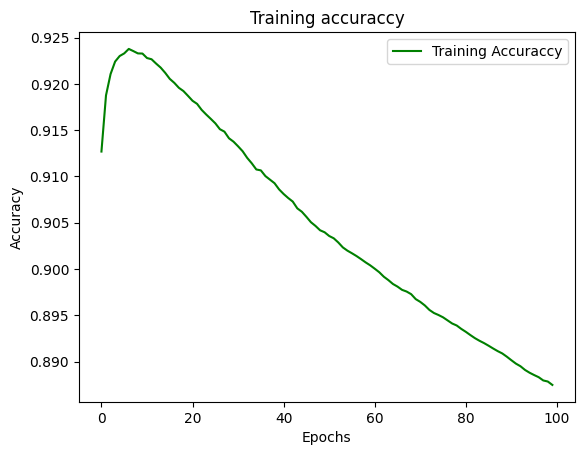

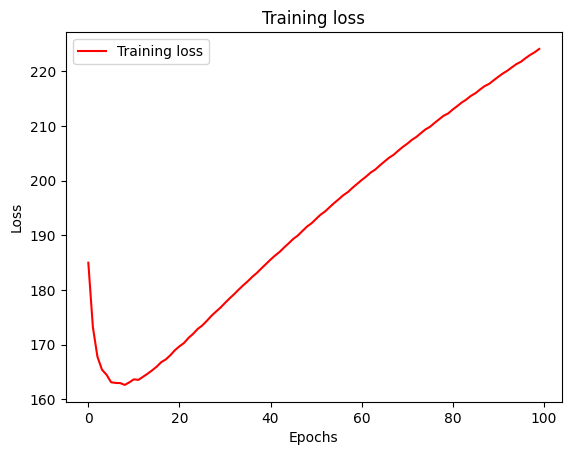

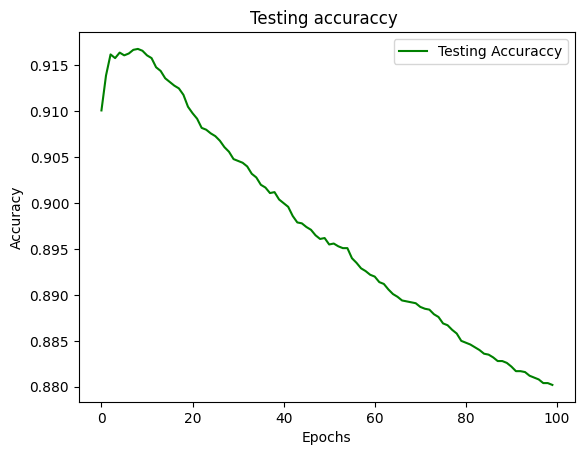

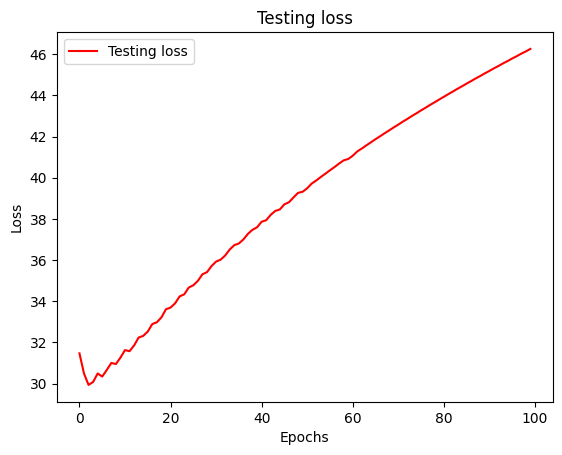

In [11]:
result = LogisticRegression(
    train_X, test_X, train_y, test_y, lr=0.005, batch_size=100, epoch=100)


In [ ]:
hyper_param = {
    "lr": [0.0025, 0.005],
    "epochs": [15, 100],
    "batch": [100, 10],
    "learning_decay": [0, 1],
    "decay_factor": [0.75, 0.5],
    "momentum": [0, 1],
    "mu": [0.9, 0.9]
}


In [12]:
best_train_acc = result[0]
best_test_acc = result[2]

best_train_acc = best_train_acc[np.argmax(best_train_acc)]
best_test_acc = best_test_acc[np.argmax(best_test_acc)]

print('Best training accuracy achieved at epoch : ', np.argmax(result[0]))
print('Best test accuracy achieved at epoch : ', np.argmax(result[2]))
best_train_acc, best_test_acc


Best training accuracy achieved at epoch :  6
Best test accuracy achieved at epoch :  8


(0.9237666666666666, 0.9168)

# PCA

In [ ]:
seq = np.random.randint(0,60000,20000)
train_sampled_X = original_train_X[seq]
train_sampled_y = original_train_y[seq]
test_y = original_test_y
train_y = train_sampled_y

# Normalize Data:
sc = StandardScaler()

# First fit then transform
train_sampled_X = sc.fit_transform(train_sampled_X)
original_test_X = sc.transform(original_test_X)

train_X,test_X = dim_reduction('pca','rbf',train_sampled_X,original_test_X,train_sampled_y)


  0%|          | 0/15 [00:00<?, ?it/s]

-- Train:  0 : Accuraccy =  0.8812666666666666 	Error:  268.1854235196071  --
-- Test:  0 : Accuraccy =  0.8844 	Error:  43.585054822061636  --


  7%|▋         | 1/15 [01:07<15:43, 67.36s/it]

-- Train:  1 : Accuraccy =  0.8953666666666666 	Error:  229.16670692571725  --
-- Test:  1 : Accuraccy =  0.8971 	Error:  37.43378082113133  --


 13%|█▎        | 2/15 [01:14<06:53, 31.83s/it]

-- Train:  2 : Accuraccy =  0.9011666666666667 	Error:  212.33539306458636  --
-- Test:  2 : Accuraccy =  0.9026 	Error:  34.86078911605552  --


 20%|██        | 3/15 [01:20<04:03, 20.27s/it]

-- Train:  3 : Accuraccy =  0.9051833333333333 	Error:  202.39744192493293  --
-- Test:  3 : Accuraccy =  0.9061 	Error:  33.38885165774594  --


 27%|██▋       | 4/15 [01:27<02:43, 14.82s/it]

-- Train:  4 : Accuraccy =  0.9081333333333333 	Error:  195.66138077902397  --
-- Test:  4 : Accuraccy =  0.9088 	Error:  32.42339946658511  --


 33%|███▎      | 5/15 [01:33<01:58, 11.83s/it]

-- Train:  5 : Accuraccy =  0.9102333333333333 	Error:  190.72098487803643  --
-- Test:  5 : Accuraccy =  0.9095 	Error:  31.7393123693422  --


 47%|████▋     | 7/15 [01:46<01:10,  8.87s/it]

-- Train:  6 : Accuraccy =  0.9121333333333334 	Error:  186.9056755361991  --
-- Test:  6 : Accuraccy =  0.9116 	Error:  31.22974392549548  --
-- Train:  7 : Accuraccy =  0.9136666666666666 	Error:  183.8498285019371  --
-- Test:  7 : Accuraccy =  0.9127 	Error:  30.836486599413348  --


 53%|█████▎    | 8/15 [01:53<00:56,  8.12s/it]

-- Train:  8 : Accuraccy =  0.9149 	Error:  181.33514935073268  --
-- Test:  8 : Accuraccy =  0.9131 	Error:  30.524993203264003  --


 67%|██████▋   | 10/15 [02:06<00:36,  7.26s/it]

-- Train:  9 : Accuraccy =  0.9160666666666667 	Error:  179.2221802847418  --
-- Test:  9 : Accuraccy =  0.914 	Error:  30.27324794308943  --
-- Train:  10 : Accuraccy =  0.9168166666666666 	Error:  177.41711198646496  --
-- Test:  10 : Accuraccy =  0.9145 	Error:  30.06650830474046  --


 73%|███████▎  | 11/15 [02:12<00:28,  7.03s/it]

-- Train:  11 : Accuraccy =  0.9175666666666666 	Error:  175.8541429226725  --


 80%|████████  | 12/15 [02:19<00:20,  6.86s/it]

-- Test:  11 : Accuraccy =  0.915 	Error:  29.894537904894847  --
-- Train:  12 : Accuraccy =  0.91805 	Error:  174.48548978507327  --


 87%|████████▋ | 13/15 [02:25<00:13,  6.78s/it]

-- Test:  12 : Accuraccy =  0.9155 	Error:  29.750023703995012  --
-- Train:  13 : Accuraccy =  0.9184 	Error:  173.27550996090238  --


 93%|█████████▎| 14/15 [02:32<00:06,  6.72s/it]

-- Test:  13 : Accuraccy =  0.9159 	Error:  29.627620293124888  --


100%|██████████| 15/15 [02:39<00:00,  6.86s/it]

-- Train:  14 : Accuraccy =  0.9188833333333334 	Error:  172.19707556852813  --
-- Test:  14 : Accuraccy =  0.9165 	Error:  29.523336676394027  --


100%|██████████| 15/15 [02:39<00:00, 10.64s/it]


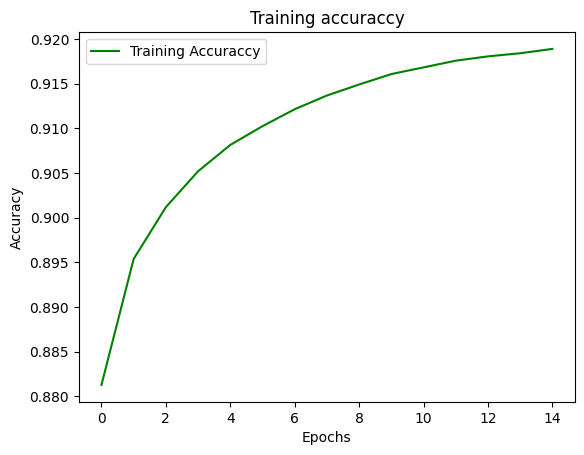

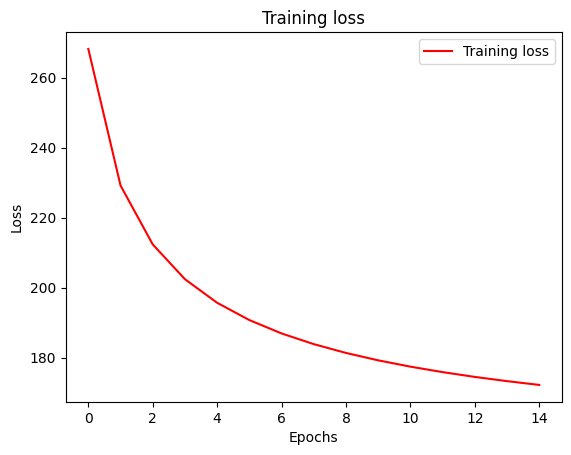

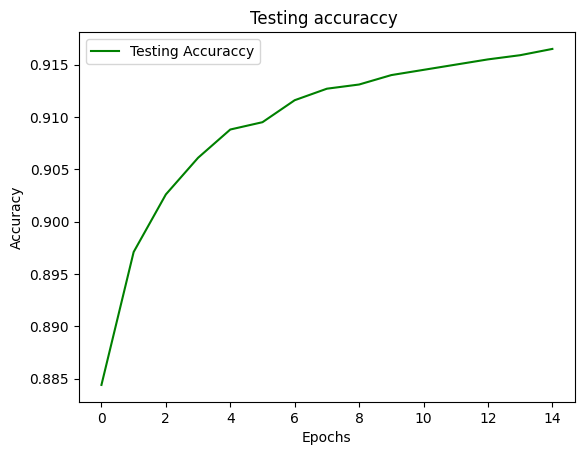

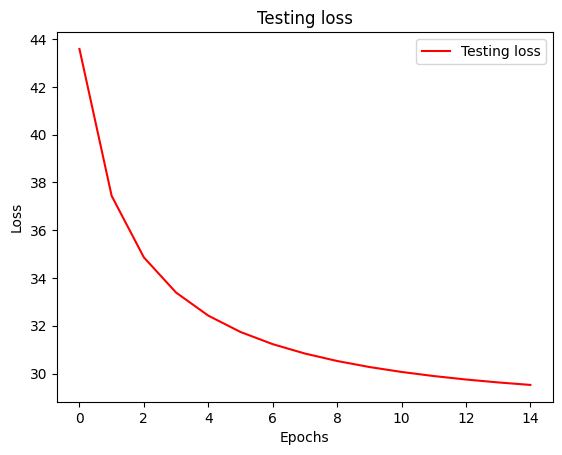

In [25]:
result_pca_rbf = LogisticRegression(train_X, test_X, train_y, test_y, lr=0.0025, batch_size=500, epoch=15)

In [26]:
best_train_acc = result_pca_rbf[0]
best_test_acc = result_pca_rbf[2]

best_train_acc = best_train_acc[np.argmax(best_train_acc)]
best_test_acc = best_test_acc[np.argmax(best_test_acc)]

best_train_acc, best_test_acc


(0.9188833333333334, 0.9165)

# LDA

In [27]:
seq = np.random.randint(0,60000,20000)
train_sampled_X = original_train_X[seq]
train_sampled_y = original_train_y[seq]
test_y = original_test_y
train_y = train_sampled_y

# Normalize Data:
sc = StandardScaler()

# First fit then transform
train_sampled_X = sc.fit_transform(train_sampled_X)
original_test_X = sc.transform(original_test_X)

train_X,test_X = dim_reduction('lda','rbf',train_sampled_X,original_test_X,train_sampled_y)


  7%|▋         | 1/15 [00:00<00:10,  1.28it/s]

-- Train:  0 : Accuraccy =  0.71525 	Error:  270.47898345836785  --
-- Test:  0 : Accuraccy =  0.7022 	Error:  137.85330555341676  --


 13%|█▎        | 2/15 [00:01<00:10,  1.27it/s]

-- Train:  1 : Accuraccy =  0.8489 	Error:  175.6155532900662  --
-- Test:  1 : Accuraccy =  0.8292 	Error:  92.21346782230707  --


 20%|██        | 3/15 [00:02<00:09,  1.26it/s]

-- Train:  2 : Accuraccy =  0.86475 	Error:  139.26127447985442  --
-- Test:  2 : Accuraccy =  0.8476 	Error:  75.03319334817533  --


 27%|██▋       | 4/15 [00:03<00:08,  1.27it/s]

-- Train:  3 : Accuraccy =  0.8719 	Error:  121.14043690027125  --
-- Test:  3 : Accuraccy =  0.8553 	Error:  66.5846657510757  --


 33%|███▎      | 5/15 [00:03<00:07,  1.27it/s]

-- Train:  4 : Accuraccy =  0.876 	Error:  110.4208258555233  --
-- Test:  4 : Accuraccy =  0.8591 	Error:  61.65175485457695  --


 40%|████      | 6/15 [00:04<00:07,  1.27it/s]

-- Train:  5 : Accuraccy =  0.8787 	Error:  103.3466351739482  --
-- Test:  5 : Accuraccy =  0.8621 	Error:  58.43939028627651  --


 47%|████▋     | 7/15 [00:05<00:06,  1.27it/s]

-- Train:  6 : Accuraccy =  0.87995 	Error:  98.32564802412108  --
-- Test:  6 : Accuraccy =  0.864 	Error:  56.190134320688585  --


 53%|█████▎    | 8/15 [00:06<00:05,  1.27it/s]

-- Train:  7 : Accuraccy =  0.8812 	Error:  94.57486922601647  --
-- Test:  7 : Accuraccy =  0.8648 	Error:  54.532998049157875  --


 60%|██████    | 9/15 [00:07<00:04,  1.27it/s]

-- Train:  8 : Accuraccy =  0.88295 	Error:  91.66517373237157  --
-- Test:  8 : Accuraccy =  0.8663 	Error:  53.26544111422299  --


 67%|██████▋   | 10/15 [00:07<00:03,  1.26it/s]

-- Train:  9 : Accuraccy =  0.88375 	Error:  89.34164674737791  --
-- Test:  9 : Accuraccy =  0.8672 	Error:  52.267613056847715  --


 73%|███████▎  | 11/15 [00:08<00:03,  1.26it/s]

-- Train:  10 : Accuraccy =  0.88495 	Error:  87.44322445260418  --
-- Test:  10 : Accuraccy =  0.8675 	Error:  51.46408829912951  --


 80%|████████  | 12/15 [00:09<00:02,  1.26it/s]

-- Train:  11 : Accuraccy =  0.8856 	Error:  85.86307266951202  --
-- Test:  11 : Accuraccy =  0.8676 	Error:  50.805041050812264  --


 87%|████████▋ | 13/15 [00:10<00:01,  1.26it/s]

-- Train:  12 : Accuraccy =  0.8864 	Error:  84.52749198012647  --
-- Test:  12 : Accuraccy =  0.8683 	Error:  50.25624368219341  --


 93%|█████████▎| 14/15 [00:11<00:00,  1.25it/s]

-- Train:  13 : Accuraccy =  0.88735 	Error:  83.38397044377415  --
-- Test:  13 : Accuraccy =  0.8684 	Error:  49.79341400523063  --


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]

-- Train:  14 : Accuraccy =  0.88785 	Error:  82.3940650144912  --
-- Test:  14 : Accuraccy =  0.8687 	Error:  49.39885429923788  --


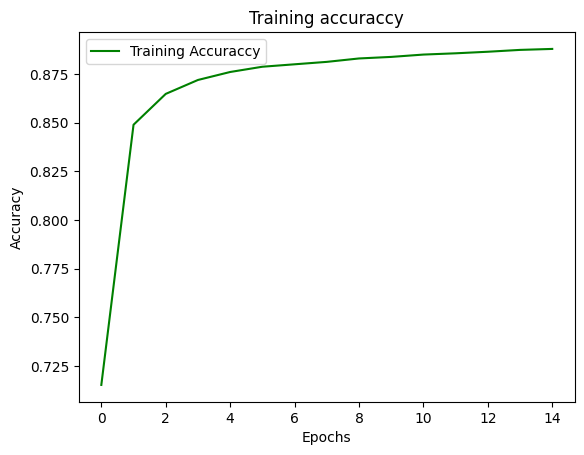

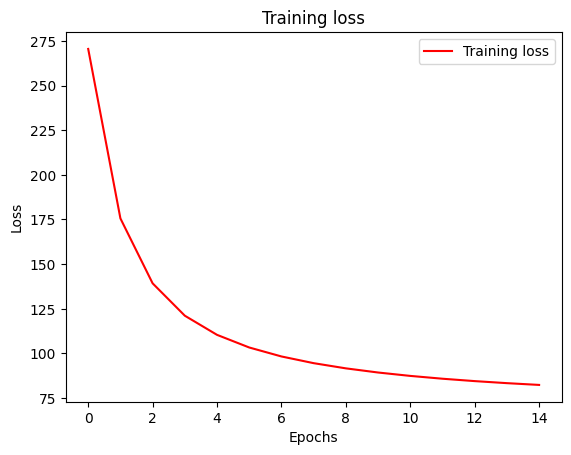

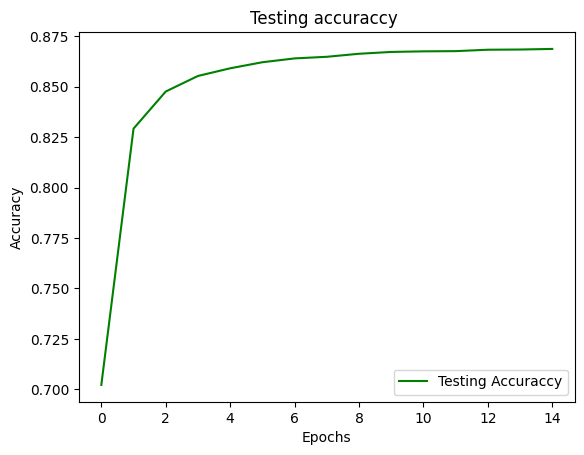

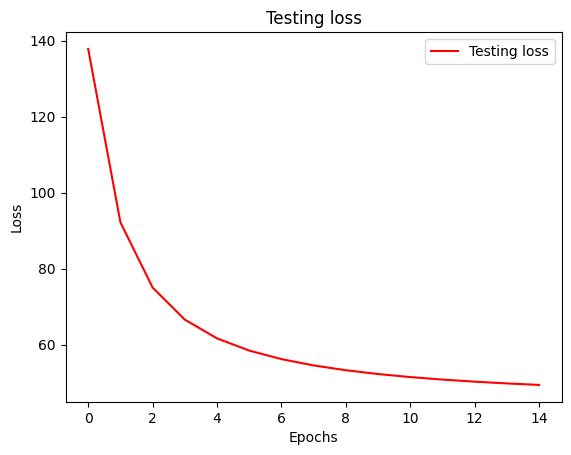

In [28]:
result_lda_rbf = LogisticRegression(train_X, test_X, train_y, test_y, lr=0.0025, batch_size=500, epoch=15)

In [29]:
best_train_acc = result_lda_rbf[0]
best_test_acc = result_lda_rbf[2]

best_train_acc = best_train_acc[np.argmax(best_train_acc)]
best_test_acc = best_test_acc[np.argmax(best_test_acc)]

best_train_acc, best_test_acc


(0.88785, 0.8687)